# NAS-BNN Full Pipeline for WakeVision Dataset

This notebook orchestrates the entire NAS-BNN pipeline for the WakeVision dataset (person detection).
It includes:

0.  Data Preparation (`prepare_local_wake_vision_from_csv.py`)
0.5. Supernet OPs Range Check (`check_ops.py`)
1.  Supernet Training (`train.py`)
2.  Evolutionary Architecture Search (`search.py`)
2.5. Inspection of Search Results (Manual Step Placeholder)
3.  Testing of Searched Architectures (`test.py`)
4.  Fine-tuning of Searched Architectures (`train_single.py`)

**Dataset Evolution:** This pipeline was originally developed for ImageNet, adapted for CIFAR-10, and is now configured for WakeVision dataset.

**Important Notes Before Running:**
*   Ensure your Python environment (e.g., `nasbnn`) is selected as the kernel for this notebook.
*   It's recommended to set the `CUDA_VISIBLE_DEVICES` environment variable in the terminal *before* launching Jupyter Lab/Notebook for consistent GPU selection by PyTorch, e.g., `set CUDA_VISIBLE_DEVICES=0` (cmd) or `$env:CUDA_VISIBLE_DEVICES="0"` (PowerShell). While we try to set it in the first code cell, its effect on `!` shell commands can sometimes be limited to that cell.
*   The script uses placeholder values for OPs ranges and keys to test/finetune. You will be prompted to review/update these after certain steps. For a fully automated run without intervention, you would need to pre-set these accurately.
*   Long-running cells (especially Supernet Training and Search) are generally more robustly run from standalone scripts in a terminal. This notebook is primarily for demonstration and step-by-step execution.

In [1]:
import os
import subprocess
import torch 
import re 
import pandas as pd 
from IPython.display import display 
import matplotlib.pyplot as plt
import seaborn as sns
import ast 

print("--- Initial Environment Setup and Configuration for Wake Vision ---")

# --- Configuration Variables ---
# >>>>> DATASET AND ARCHITECTURE CONFIGURATION FOR WAKE VISION <<<<<
dataset_name = "WakeVision"
architecture_name = "superbnn_wakevision_large" 
global_workers = 0 

# VVVVVV ADD THIS NEW CONFIGURATION VARIABLE VVVVVV
wakevision_img_size = 128 # Define the image size for WakeVision (e.g., 128, 96)
# This should match what prepare_wakevision.py uses for TARGET_IMAGE_SIZE
# and what superbnn_wakevision_large in models/superbnn.py expects.
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

data_path = "./data/WakeVision_From_Local_SSD_V3" # Ensure this is where prepare_wakevision.py saves data
base_work_dir = "./work_dirs/wakevision_nasbnn_LARGEXP_run" 
supernet_checkpoint_path = f"{base_work_dir}/checkpoint.pth.tar"
search_output_dir = f"{base_work_dir}/search"
search_info_file = f"{search_output_dir}/info.pth.tar"

# Supernet Training Params for Wake Vision
train_supernet_epochs = 10       
train_supernet_batch_size = 64   # You changed this to 64, which is good.
train_supernet_lr = "2.5e-3"     
train_supernet_wd = "5e-6"       

# Search Params for Wake Vision
search_max_epochs = 10           
search_population_num = 50       
search_m_prob = 0.2              
search_crossover_num = 10        
search_mutation_num = 10         
search_ops_min = 3.8             # From your previous successful check_ops for superbnn_cifar10_large. 
search_ops_max = 6.2             # For superbnn_wakevision_large, this needs to be updated after Cell 6.
search_step = 0.2                
search_max_train_iters = 10      
search_train_batch_size = 64     
search_test_batch_size = 64      

# Test Params
test_max_train_iters = 10
test_train_batch_size = 64       
test_test_batch_size = 64        
ops_key_to_test1 = 5             
ops_key_to_test2 = 6
test_img_size = 128             

# Fine-tuning Params
finetune_batch_size = 64 # You changed this from 1024, which is good.
finetune_lr = "5e-5" 
finetune_wd = 0
finetune_epochs = 50 # You changed this, also reasonable.

# --- Environment Variable Setup ---
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
os.environ["PYTHONUNBUFFERED"] = "1"
print(f"INFO: Attempted to set CUDA_VISIBLE_DEVICES to: {os.environ.get('CUDA_VISIBLE_DEVICES')}")
print(f"INFO: Attempted to set PYTHONUNBUFFERED to: {os.environ.get('PYTHONUNBUFFERED')}")
print(f"INFO: Current working directory: {os.getcwd()}")
print(f"INFO: Output for this run will be in: {base_work_dir}")
print("---------------------------------")

# --- CUDA Installation and GPU Check ---
print("--- CUDA Installation and GPU Check ---")
if 'torch' not in globals(): import torch 
print(f"PyTorch version: {torch.__version__}") 
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version reported by PyTorch (torch.version.cuda): {torch.version.cuda}")
    print(f"Number of GPUs available to PyTorch: {torch.cuda.device_count()}")
    try:
        cuda_device_idx = 0 
        torch.cuda.set_device(cuda_device_idx) 
        print(f"Current PyTorch CUDA device (after setting to {cuda_device_idx}): {torch.cuda.current_device()}")
        print(f"GPU name for PyTorch cuda:{cuda_device_idx}: {torch.cuda.get_device_name(torch.cuda.current_device())}")
        print("\nAttempting a small model and tensor operation on CUDA device...")
        model_test = torch.nn.Linear(10,1).to(torch.device(f"cuda:{cuda_device_idx}"))
        if list(model_test.parameters()):
             pass
        else: print("Test model has no parameters.")
        a = torch.randn(5, 10).to(torch.device(f"cuda:{cuda_device_idx}"))
        b = model_test(a)
        print(f"Small CUDA op successful. Output sum: {b.sum().item()}")
    except Exception as e:
        print(f"Error during CUDA operations: {e}")
else:
    print("CUDA not available, cannot perform GPU tests with PyTorch CUDA backend.")

cuda_visible_devices_env = os.environ.get('CUDA_VISIBLE_DEVICES')
print(f"\nChecking environment variable CUDA_VISIBLE_DEVICES (as seen by Python os.environ):")
if cuda_visible_devices_env:
    print(f"CUDA_VISIBLE_DEVICES is set to: {cuda_visible_devices_env}")
else:
    print("CUDA_VISIBLE_DEVICES is NOT set or is empty in os.environ.")
print("---------------------------------")

# --- Helper Function for Log Parsing (used by Analysis Cells later) ---
def parse_accuracy_from_log(log_file_path):
    top1_accuracy = None
    if not os.path.exists(log_file_path):
        print(f"Warning: Log file not found at {log_file_path}")
        return None
    try:
        with open(log_file_path, 'r') as f: lines = f.readlines()
        for line in reversed(lines):
            match_test = re.search(r"INFO - top1: (\d+\.\d+)", line)
            if match_test: top1_accuracy = float(match_test.group(1)); break
            match_train_single = re.search(r"INFO -  \* Acc@1 (\d+\.\d+)", line)
            if match_train_single: top1_accuracy = float(match_train_single.group(1)); break
        if top1_accuracy is not None: print(f"Parsed accuracy {top1_accuracy:.2f}% from {os.path.basename(log_file_path)}")
        else: print(f"Warning: Could not parse Top-1 accuracy from {log_file_path}")
    except Exception as e: print(f"Error parsing log file {log_file_path}: {e}"); return None
    return top1_accuracy
# --- End Helper Function ---

os.makedirs(base_work_dir, exist_ok=True) 
print(f"INFO: Ensured base work directory exists: {base_work_dir}")
print("--- Configuration and Setup Cell Complete ---")

--- Initial Environment Setup and Configuration for Wake Vision ---
INFO: Attempted to set CUDA_VISIBLE_DEVICES to: 0
INFO: Attempted to set PYTHONUNBUFFERED to: 1
INFO: Current working directory: c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test08
INFO: Output for this run will be in: ./work_dirs/wakevision_nasbnn_LARGEXP_run
---------------------------------
--- CUDA Installation and GPU Check ---
PyTorch version: 2.7.0+cu128
CUDA available: True
CUDA version reported by PyTorch (torch.version.cuda): 12.8
Number of GPUs available to PyTorch: 1
Current PyTorch CUDA device (after setting to 0): 0
GPU name for PyTorch cuda:0: NVIDIA GeForce RTX 4050 Laptop GPU

Attempting a small model and tensor operation on CUDA device...
Small CUDA op successful. Output sum: 1.3073546886444092

Checking environment variable CUDA_VISIBLE_DEVICES (as seen by Python os.environ):
CUDA_VISIBLE_DEVICES is set to: 0
---------------------------------
INFO: Ensured base work directory exists: ./w

## Step 0: Prepare Wake Vision Data from Local CSV and Images

This step runs `prepare_local_wake_vision_from_csv.py`. This script will:
1. Read image filenames and labels from your local `wake_vision_train_large.csv`.
2. Locate the corresponding image files in your local `extracted_train_images` directory.
3. Select a subset of these images based on `TOTAL_SUBSET_SIZE`.
4. Process and resize these selected images.
5. Split the subset into `train` and `val` sets.
6. Structure these sets into the `ImageFolder` format in the directory specified by `TARGET_OUTPUT_BASE_DIR` (e.g., `./data/WakeVision_From_Local_SSD/`) as expected by subsequent scripts.

**ACTION REQUIRED BEFORE RUNNING CELL 4:**
*   Ensure you have the `pandas` and `scikit-learn` libraries installed (`pip install pandas scikit-learn Pillow tqdm`).
*   Open `prepare_local_wake_vision_from_csv.py` and **configure all paths and parameters at the top of that script**:
    *   `LOCAL_WAKE_VISION_BASE_DIR` (e.g., `"./WakeVision"` if Test08 is current dir)
    *   `EXTRACTED_IMAGES_SUBDIR` (e.g., `"extracted_train_images"`)
    *   `TRAIN_METADATA_CSV_FILENAME` (e.g., `"wake_vision_train_large.csv"`)
    *   `TARGET_OUTPUT_BASE_DIR` (e.g., `"./data/WakeVision_From_Local_SSD"`) - **Note:** The `data_path` variable in Cell 2 of this notebook should match this `TARGET_OUTPUT_BASE_DIR`.
    *   `TOTAL_SUBSET_SIZE` (e.g., `200000` for a substantial run, or much smaller like `1000` for initial pipeline testing).
    *   `TARGET_IMAGE_SIZE` (e.g., `(128, 128)`).
    *   `IMAGE_FILENAME_COLUMN_IN_CSV`, `LABEL_COLUMN_IN_CSV`, `POSITIVE_LABEL_VALUE_IN_CSV`, `CLASS_MAP_FOR_SAVING`.

In [1]:
import sys # Ensure sys is imported for sys.executable
import os # For path joining for clarity, though not strictly needed by subprocess here

# Configuration from Cell 2 (ensure Cell 2 has been run)
# Variables like dataset_name and data_path are used from Cell 2 for print statements.

# Define the script to be run
data_preparation_script_name = "prepare_local_wake_vision_from_csv.py" # <<< CORRECTED FILENAME

print(f"Step 0: Preparing {dataset_name} Data using local files...") # dataset_name from Cell 2
print(f"INFO: This will run '{data_preparation_script_name}'.")
print(f"      Please ensure all paths and subset configurations are correctly set inside '{data_preparation_script_name}'.")

# Construct the command
command_to_run_prep = [sys.executable, data_preparation_script_name]
print(f"Executing: {' '.join(command_to_run_prep)}")

try:
    process = subprocess.run(command_to_run_prep, capture_output=True, text=True, check=False) 
    
    print(f"\n--- Output from {data_preparation_script_name} ---")
    if process.stdout:
        print("STDOUT:")
        print(process.stdout)
    if process.stderr: 
        print("STDERR:")
        print(process.stderr)
    print(f"--- End of {data_preparation_script_name} Output ---\n")

    if process.returncode != 0:
        print(f"ERROR: {data_preparation_script_name} exited with code {process.returncode}. Check output above. Pipeline halted.")
        raise SystemExit(f"Data preparation failed for {dataset_name}") 
    else:
        print(f"INFO: {dataset_name} Data Preparation assumed complete based on script exit code.")
        # data_path is from Cell 2 and should match TARGET_OUTPUT_BASE_DIR in the prep script
        print(f"      Data should now be in: {os.path.abspath(data_path)}") 

except FileNotFoundError:
    print(f"ERROR: Could not find script '{data_preparation_script_name}' or Python interpreter '{sys.executable}'.")
    raise
except Exception as e:
    print(f"An unexpected error occurred while running {data_preparation_script_name}: {e}")
    raise

NameError: name 'dataset_name' is not defined

## Step 0.5: Check Supernet OPs Range for WakeVision

This step runs `check_ops.py` for the `superbnn_wakevision_large` architecture to determine its theoretical minimum and maximum OPs (Mega Operations).

**ACTION:**
1.  Ensure `architecture_name` in Cell 2 is set to `"superbnn_wakevision_large"`.
2.  Ensure `wakevision_img_size` in Cell 2 is set to the correct input image dimension (e.g., 128).
3.  Run this cell.
4.  Review the outputted OPs range.
5.  **Go back to Cell 2 and update the `search_ops_min` and `search_ops_max` variables** to bracket your target OPs (e.g., ~5M) within the reported feasible range.
6.  **Re-run Cell 2** to apply these changes to the notebook's variables.
7.  Then, press Enter in the input box below to continue the pipeline.

In [4]:
import subprocess
import sys

print("Step 0.5: Check Supernet OPs Range...")

# These variables are defined in Cell 2. Ensure Cell 2 has been run.
# architecture_name should be "superbnn_wakevision_large"
# wakevision_img_size should be defined (e.g., 128)

# Construct command for check_ops.py
command_to_run_check_ops = [
    sys.executable, 
    "check_ops.py", 
    "-a", architecture_name,
    "--img-size", str(wakevision_img_size) # Pass img_size to check_ops.py
]
print(f"Running: {' '.join(command_to_run_check_ops)}")

try:
    result = subprocess.run(command_to_run_check_ops, capture_output=True, text=True, check=False)
    
    print("\n--- Output from check_ops.py ---")
    if result.stdout: print("STDOUT:\n" + result.stdout)
    if result.stderr: print("STDERR:\n" + result.stderr) # Errors from argparse go here
    print("--- End of check_ops.py Output ---\n")

    if result.returncode != 0:
        print(f"WARNING: check_ops.py ran with errors (return code: {result.returncode}). Please check output above.")

except FileNotFoundError:
    print(f"ERROR: Could not find script 'check_ops.py' or Python interpreter '{sys.executable}'.")
except Exception as e:
    print(f"An unexpected error occurred while running check_ops.py: {e}")

# search_ops_min and search_ops_max are from Cell 2's current definition
print(f"ACTION: Review OPs range from output. Current notebook config SearchOpsMin = {search_ops_min}, SearchOpsMax = {search_ops_max}.")
input("Press Enter to continue once OPs parameters in Cell 2 are reviewed/updated AND CELL 2 IS RE-RUN, or stop kernel.")

Step 0.5: Check Supernet OPs Range...
Running: c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test08\nasbnn\Scripts\python.exe check_ops.py -a superbnn_wakevision_large --img-size 128

--- Output from check_ops.py ---
STDOUT:
Checking OPs for architecture: superbnn_wakevision_large with image size: 128x128
Smallest candidate OPs: 1.74 M
Biggest candidate OPs: 70.88 M

--- End of check_ops.py Output ---

ACTION: Review OPs range from output. Current notebook config SearchOpsMin = 3.8, SearchOpsMax = 6.2.


''

## Step 1: Train Supernet
This step trains the `superbnn_wakevision_large` supernet. This can be time-consuming.
Output will be in the `$BaseWorkDir` defined in Cell 2.

In [2]:
# Cell 8: Code (Train Supernet - MODIFIED FOR RESUME)

print(f"Step 1: Training Supernet (Output: {base_work_dir})...")
# Ensure base_work_dir is created (already done in Cell 2 if it's the same var)
os.makedirs(base_work_dir, exist_ok=True)

# Construct the base command
train_command_list = [
    "python", "train.py",
    "--dataset", dataset_name,
    "-a", architecture_name,
    "--img-size", str(wakevision_img_size), # Add img-size if train.py expects it
    "-b", str(train_supernet_batch_size),
    "--lr", train_supernet_lr,
    "--wd", train_supernet_wd,
    "--epochs", str(train_supernet_epochs),
    data_path, # This is args.data for train.py
    base_work_dir, # This is args.logdir for train.py
    "--gpu", "0",
    "--workers", str(global_workers),
    "--print-freq", "50",
    "--save-freq", "1" # Changed to 1 for more frequent saves during long WakeVision training
]

# Check if a checkpoint exists to resume from
# supernet_checkpoint_path is defined in Cell 2 as f"{base_work_dir}/checkpoint.pth.tar"
if os.path.exists(supernet_checkpoint_path):
    print(f"INFO: Found existing supernet checkpoint: {supernet_checkpoint_path}. Adding --resume to command.")
    resume_path = os.path.abspath(supernet_checkpoint_path)  # Get absolute path
    train_command_list.extend(["--resume", resume_path])
else:
    print(f"INFO: No existing supernet checkpoint found at {supernet_checkpoint_path}. Starting training from scratch.")

# Join list to string for execution with !
train_command_str = " ".join(train_command_list)
print(f"DEBUG: Executing train command: {train_command_str}")

# Execute the command
# Using ! for direct shell execution. 
# If issues with complex args or paths with spaces, subprocess is more robust but ! is okay here.
!{train_command_str}

print(f"INFO: Supernet Training assumed complete/progressed. Checkpoint: {supernet_checkpoint_path}")

Step 1: Training Supernet (Output: ./work_dirs/wakevision_nasbnn_LARGEXP_run)...
INFO: Found existing supernet checkpoint: ./work_dirs/wakevision_nasbnn_LARGEXP_run/checkpoint.pth.tar. Adding --resume to command.
DEBUG: Executing train command: python train.py --dataset WakeVision -a superbnn_wakevision_large --img-size 128 -b 64 --lr 2.5e-3 --wd 5e-6 --epochs 10 ./data/WakeVision_From_Local_SSD_V3 ./work_dirs/wakevision_nasbnn_LARGEXP_run --gpu 0 --workers 0 --print-freq 50 --save-freq 1 --resume c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test08\work_dirs\wakevision_nasbnn_LARGEXP_run\checkpoint.pth.tar
Use GPU: 0 for training
INFO: Supernet Training assumed complete/progressed. Checkpoint: ./work_dirs/wakevision_nasbnn_LARGEXP_run/checkpoint.pth.tar


c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test08\train.py:201: UserWarning: You have chosen a specific GPU. This will completely disable data parallelism.
  warnings.warn('You have chosen a specific GPU. This will completely '
2025-06-19 00:22:07,709 - Train - INFO - Namespace(data='./data/WakeVision_From_Local_SSD_V3', logdir='./work_dirs/wakevision_nasbnn_LARGEXP_run', arch='superbnn_wakevision_large', dataset='WakeVision', workers=0, epochs=10, start_epoch=0, warm_up=False, warm_up_multiplier=1, warm_up_epochs=5, cutout=False, cutout_length=16, label_smooth=0.1, batch_size=64, lr=0.0025, lr_scheduler='CosineAnnealingLR', step_size=30, gamma=0.1, milestones=[80, 120], momentum=0.9, weight_decay=5e-06, distill=False, print_freq=50, save_freq=1, resume='c:\\Users\\SMoha\\Desktop\\Temporary\\UniGe\\Internship\\NAS-BNN\\Test08\\work_dirs\\wakevision_nasbnn_LARGEXP_run\\checkpoint.pth.tar', evaluate=False, world_size=-1, rank=-1, dist_url='tcp://224.66.41.62:23456', dist_b

## Step 2: Search Architectures
This step performs the evolutionary search using the trained supernet. This can also be time-consuming.
Output will be in `$SearchOutputDir`.

In [2]:
print(f"Step 2: Searching Architectures (Output: {search_output_dir})...")
print(f"INFO: Using SearchOpsMin: {search_ops_min}, SearchOpsMax: {search_ops_max}")
os.makedirs(search_output_dir, exist_ok=True)

search_command = f"""
python search.py \
    --dataset {dataset_name} \
    -a {architecture_name} \
    --max-epochs {search_max_epochs} \
    --population-num {search_population_num} \
    --m-prob {search_m_prob} \
    --crossover-num {search_crossover_num} \
    --mutation-num {search_mutation_num} \
    --ops-min {search_ops_min} \
    --ops-max {search_ops_max} \
    --step {search_step} \
    --max-train-iters {search_max_train_iters} \
    --train-batch-size {search_train_batch_size} \
    --test-batch-size {search_test_batch_size} \
    --workers {global_workers} \
    {supernet_checkpoint_path} \
    {data_path} \
    {search_output_dir} \
    --gpu 0
"""
search_command_single_line = " ".join(search_command.split())
!{search_command_single_line}
print(f"INFO: Search assumed complete. Results: {search_info_file}")

Step 2: Searching Architectures (Output: ./work_dirs/wakevision_nasbnn_LARGEXP_run/search)...
INFO: Using SearchOpsMin: 3.8, SearchOpsMax: 6.2
INFO: Search assumed complete. Results: ./work_dirs/wakevision_nasbnn_LARGEXP_run/search/info.pth.tar


c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test08\search.py:714: UserWarning: You have chosen a specific GPU. This will completely disable data parallelism.
  warnings.warn('You have chosen a specific GPU. This will completely '
2025-06-19 10:30:59,044 - Search - INFO - Namespace(supernet='./work_dirs/wakevision_nasbnn_LARGEXP_run/checkpoint.pth.tar', data='./data/WakeVision_From_Local_SSD_V3', logdir='./work_dirs/wakevision_nasbnn_LARGEXP_run/search', arch='superbnn_wakevision_large', dataset='WakeVision', workers=0, max_epochs=10, population_num=50, m_prob=0.2, crossover_num=10, mutation_num=10, ops_min=3.8, ops_max=6.2, step=0.2, max_train_iters=10, train_batch_size=64, test_batch_size=64, gpu=0, world_size=-1, rank=-1, dist_url='tcp://224.66.41.62:23456', dist_backend='nccl', seed=0, multiprocessing_distributed=False, distributed=False)
2025-06-19 10:30:59,044 - Search - INFO - => creating model 'superbnn_wakevision_large'
2025-06-19 10:30:59,795 - Search - INFO - =>

Use GPU: 0 for training


## Step 2.5: Inspect Search Results
The search has produced `$SearchInfoFile`.
**ACTION:** Inspect this file to identify the keys for promising architectures. You can use your `info.pth.tar.py` script or the Python one-liner provided in the PowerShell script.
The notebook will pause here. **Manually update the `ops_key_to_test1` and `ops_key_to_test2` variables in Cell 2 (Configuration) with the keys you want to test/fine-tune, then re-run Cell 2** before proceeding to the next steps.

In [8]:
print(f"Step 2.5: Inspect Search Results from: {search_info_file}")
print(f"ACTION: Manually update ops_key_to_test1/ops_key_to_test2 in Cell 2 if the defaults ({ops_key_to_test1}, {ops_key_to_test2}) are not desired.")
# Example one-liner to print keys (run this in a new cell if you want to see output before continuing)
# !python -c "import torch; r = torch.load('{search_info_file}', map_location='cpu'); print('Pareto Keys:', r.get('pareto_global', {{}}).keys())"
input("Press Enter in the input box below once you have reviewed search results and updated keys in Cell 2 (if needed). Then RE-RUN CELL 2 before running next cells.")

Step 2.5: Inspect Search Results from: ./work_dirs/wakevision_nasbnn_LARGEXP_run/search/info.pth.tar
ACTION: Manually update ops_key_to_test1/ops_key_to_test2 in Cell 2 if the defaults (5, 6) are not desired.


''

## Step 3a: Test Architecture for OPs Key 1
Testing the architecture corresponding to the first chosen OPs key.

In [9]:
test_output_dir1 = f"{search_output_dir}/test_ops_key{ops_key_to_test1}"
print(f"Step 3a: Testing Architecture for OPs Key {ops_key_to_test1} (Output: {test_output_dir1})...")
os.makedirs(test_output_dir1, exist_ok=True)

test_command1 = f"""
python test.py \
    --dataset {dataset_name} \
    -a {architecture_name} \
    --ops {ops_key_to_test1} \
    --img-size {test_img_size} \
    --max-train-iters {test_max_train_iters} \
    --train-batch-size {test_train_batch_size} \
    --test-batch-size {test_test_batch_size} \
    --workers {global_workers} \
    {supernet_checkpoint_path} \
    {data_path} \
    {search_info_file} \
    {test_output_dir1} \
    --gpu 0
"""
test_command1_single_line = " ".join(test_command1.split())
!{test_command1_single_line}
print(f"INFO: Test for OPs Key {ops_key_to_test1} assumed complete.")

Step 3a: Testing Architecture for OPs Key 5 (Output: ./work_dirs/wakevision_nasbnn_LARGEXP_run/search/test_ops_key5)...
Use GPU: 0 for training
INFO: Test for OPs Key 5 assumed complete.


c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test08\test.py:104: UserWarning: You have chosen a specific GPU. This will completely disable data parallelism.
  warnings.warn('You have chosen a specific GPU. This will completely '
2025-06-20 11:06:46,546 - Test - INFO - Namespace(supernet='./work_dirs/wakevision_nasbnn_LARGEXP_run/checkpoint.pth.tar', data='./data/WakeVision_From_Local_SSD_V3', checkpoint='./work_dirs/wakevision_nasbnn_LARGEXP_run/search/info.pth.tar', logdir='./work_dirs/wakevision_nasbnn_LARGEXP_run/search/test_ops_key5', arch='superbnn_wakevision_large', dataset='WakeVision', img_size=128, workers=0, ops=5, max_train_iters=10, train_batch_size=64, test_batch_size=64, gpu=0, world_size=-1, rank=-1, dist_url='tcp://224.66.41.62:23456', dist_backend='nccl', seed=0, multiprocessing_distributed=False, distributed=False)
2025-06-20 11:06:46,546 - Test - INFO - => creating model 'superbnn_wakevision_large'
2025-06-20 11:06:47,228 - Test - INFO - => Model for tes

## Step 3b: Test Architecture for OPs Key 2
Testing the architecture corresponding to the second chosen OPs key.

In [10]:
test_output_dir2 = f"{search_output_dir}/test_ops_key{ops_key_to_test2}"
print(f"Step 3b: Testing Architecture for OPs Key {ops_key_to_test2} (Output: {test_output_dir2})...")
os.makedirs(test_output_dir2, exist_ok=True)

test_command2 = f"""
python test.py \
    --dataset {dataset_name} \
    -a {architecture_name} \
    --ops {ops_key_to_test2} \
    --max-train-iters {test_max_train_iters} \
    --train-batch-size {test_train_batch_size} \
    --test-batch-size {test_test_batch_size} \
    --workers {global_workers} \
    {supernet_checkpoint_path} \
    {data_path} \
    {search_info_file} \
    {test_output_dir2} \
    --gpu 0
"""
test_command2_single_line = " ".join(test_command2.split())
!{test_command2_single_line}
print(f"INFO: Test for OPs Key {ops_key_to_test2} assumed complete.")

Step 3b: Testing Architecture for OPs Key 6 (Output: ./work_dirs/wakevision_nasbnn_LARGEXP_run/search/test_ops_key6)...
Use GPU: 0 for training
INFO: Test for OPs Key 6 assumed complete.


c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test08\test.py:104: UserWarning: You have chosen a specific GPU. This will completely disable data parallelism.
  warnings.warn('You have chosen a specific GPU. This will completely '
2025-06-20 11:08:45,680 - Test - INFO - Namespace(supernet='./work_dirs/wakevision_nasbnn_LARGEXP_run/checkpoint.pth.tar', data='./data/WakeVision_From_Local_SSD_V3', checkpoint='./work_dirs/wakevision_nasbnn_LARGEXP_run/search/info.pth.tar', logdir='./work_dirs/wakevision_nasbnn_LARGEXP_run/search/test_ops_key6', arch='superbnn_wakevision_large', dataset='WakeVision', img_size=None, workers=0, ops=6, max_train_iters=10, train_batch_size=64, test_batch_size=64, gpu=0, world_size=-1, rank=-1, dist_url='tcp://224.66.41.62:23456', dist_backend='nccl', seed=0, multiprocessing_distributed=False, distributed=False)
2025-06-20 11:08:45,680 - Test - INFO - => creating model 'superbnn_wakevision_large'
2025-06-20 11:08:46,314 - Test - INFO - => Model for te

## Step 4a: Fine-tune Architecture for OPs Key 1
Fine-tuning the architecture corresponding to the first chosen OPs key.

In [2]:
# Example for Cell 18 (Fine-tuning Step 4a) in run_all.ipynb

finetune_output_dir1 = f"{base_work_dir}/finetuned_ops_key{ops_key_to_test1}"
print(f"Step 4a: Fine-tuning for OPs Key {ops_key_to_test1} (Output: {finetune_output_dir1})...")
os.makedirs(finetune_output_dir1, exist_ok=True)

# Assume 'wakevision_img_size' is defined in Cell 2
finetune_command1_multiline = f"""
python train_single.py \
    --dataset {dataset_name} \
    -a {architecture_name} \
    --img-size {wakevision_img_size} \
    -b {finetune_batch_size} \
    --lr {finetune_lr} \
    --wd {finetune_wd} \
    --epochs {finetune_epochs} \
    --ops {ops_key_to_test1} \
    --workers {global_workers} \
    --pretrained {supernet_checkpoint_path} \
    {data_path} \
    {search_info_file} \
    {finetune_output_dir1} \
    --gpu 0
"""
# Check for resume for this specific fine-tuning run
resume_checkpoint_path_ft1 = os.path.join(finetune_output_dir1, "checkpoint.pth.tar")
additional_args_ft1 = ""
if os.path.exists(resume_checkpoint_path_ft1):
    print(f"INFO: Found checkpoint to RESUME fine-tuning: {resume_checkpoint_path_ft1}")
    additional_args_ft1 = f"--resume {resume_checkpoint_path_ft1}"

# Construct the single line command carefully
finetune_command1_parts = finetune_command1_multiline.split()
finetune_command1_single_line = " ".join(finetune_command1_parts)
if additional_args_ft1:
    finetune_command1_single_line += f" {additional_args_ft1}"

print(f"DEBUG: Executing fine-tune command: {finetune_command1_single_line}")

!{finetune_command1_single_line}
print(f"INFO: Fine-tuning for OPs Key {ops_key_to_test1} assumed complete/progressed.")

Step 4a: Fine-tuning for OPs Key 5 (Output: ./work_dirs/wakevision_nasbnn_LARGEXP_run/finetuned_ops_key5)...
INFO: Found checkpoint to RESUME fine-tuning: ./work_dirs/wakevision_nasbnn_LARGEXP_run/finetuned_ops_key5\checkpoint.pth.tar
DEBUG: Executing fine-tune command: python train_single.py --dataset WakeVision -a superbnn_wakevision_large --img-size 128 -b 64 --lr 5e-5 --wd 0 --epochs 50 --ops 5 --workers 0 --pretrained ./work_dirs/wakevision_nasbnn_LARGEXP_run/checkpoint.pth.tar ./data/WakeVision_From_Local_SSD_V3 ./work_dirs/wakevision_nasbnn_LARGEXP_run/search/info.pth.tar ./work_dirs/wakevision_nasbnn_LARGEXP_run/finetuned_ops_key5 --gpu 0 --resume ./work_dirs/wakevision_nasbnn_LARGEXP_run/finetuned_ops_key5\checkpoint.pth.tar
Use GPU: 0 for training
Use cosine scheduler
INFO: Fine-tuning for OPs Key 5 assumed complete/progressed.


c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test08\train_single.py:205: UserWarning: You have chosen a specific GPU. This will completely disable data parallelism.
  warnings.warn('You have chosen a specific GPU. This will completely '
2025-06-21 19:24:21,918 - Train - INFO - Namespace(data='./data/WakeVision_From_Local_SSD_V3', checkpoint='./work_dirs/wakevision_nasbnn_LARGEXP_run/search/info.pth.tar', logdir='./work_dirs/wakevision_nasbnn_LARGEXP_run/finetuned_ops_key5', arch='superbnn_wakevision_large', dataset='WakeVision', img_size=128, workers=0, ops=5, epochs=50, start_epoch=0, warm_up=False, warm_up_multiplier=1, warm_up_epochs=5, cutout=False, cutout_length=16, batch_size=64, lr=5e-05, lr_scheduler='CosineAnnealingLR', step_size=30, gamma=0.1, milestones=[80, 120], momentum=0.9, weight_decay=0.0, print_freq=100, save_freq=1, resume='./work_dirs/wakevision_nasbnn_LARGEXP_run/finetuned_ops_key5\\checkpoint.pth.tar', pretrained='./work_dirs/wakevision_nasbnn_LARGEXP

## Step 4b: Fine-tune Architecture for OPs Key 2
Fine-tuning the architecture corresponding to the second chosen OPs key.

In [2]:
# Cell for Step 4b: Fine-tuning for OPs Key ops_key_to_test2
# (Ensure Cell 2 has been run and ops_key_to_test2, wakevision_img_size, etc. are defined)

finetune_output_dir2 = f"{base_work_dir}/finetuned_ops_key{ops_key_to_test2}" # Uses ops_key_to_test2
print(f"Step 4b: Fine-tuning for OPs Key {ops_key_to_test2} (Output: {finetune_output_dir2})...")
os.makedirs(finetune_output_dir2, exist_ok=True)

# Construct the command parts list
command_parts_ft2 = [
    "python", "train_single.py",
    "--dataset", dataset_name,
    "-a", architecture_name,
    "--img-size", str(wakevision_img_size), 
    "-b", str(finetune_batch_size),
    "--lr", str(finetune_lr),
    "--wd", str(finetune_wd),
    "--epochs", str(finetune_epochs),
    "--ops", str(ops_key_to_test2), 
    "--workers", str(global_workers),
    "--pretrained", supernet_checkpoint_path,
    data_path,                           
    search_info_file,                    
    finetune_output_dir2,                
    "--gpu", "0",
    "--print-freq", "100", # Added based on your successful log
    "--save-freq", "1"     # Added based on your successful log
]

# Check for resume for this specific fine-tuning run
resume_checkpoint_path_ft2 = os.path.join(finetune_output_dir2, "checkpoint.pth.tar")
if os.path.exists(resume_checkpoint_path_ft2):
    print(f"INFO: Found checkpoint to RESUME fine-tuning for OPs Key {ops_key_to_test2}: {resume_checkpoint_path_ft2}")
    command_parts_ft2.extend(["--resume", resume_checkpoint_path_ft2])
else:
    print(f"INFO: No checkpoint found for OPs Key {ops_key_to_test2} at {resume_checkpoint_path_ft2}. Starting fine-tuning from pretrained supernet.")

# Join parts into a single command string for execution
finetune_command2_single_line = " ".join(command_parts_ft2)
print(f"DEBUG: Executing fine-tune command: {finetune_command2_single_line}")

!{finetune_command2_single_line} 

print(f"INFO: Fine-tuning for OPs Key {ops_key_to_test2} assumed complete/progressed.")

Step 4b: Fine-tuning for OPs Key 6 (Output: ./work_dirs/wakevision_nasbnn_LARGEXP_run/finetuned_ops_key6)...
INFO: Found checkpoint to RESUME fine-tuning for OPs Key 6: ./work_dirs/wakevision_nasbnn_LARGEXP_run/finetuned_ops_key6\checkpoint.pth.tar
DEBUG: Executing fine-tune command: python train_single.py --dataset WakeVision -a superbnn_wakevision_large --img-size 128 -b 64 --lr 5e-5 --wd 0 --epochs 50 --ops 6 --workers 0 --pretrained ./work_dirs/wakevision_nasbnn_LARGEXP_run/checkpoint.pth.tar ./data/WakeVision_From_Local_SSD_V3 ./work_dirs/wakevision_nasbnn_LARGEXP_run/search/info.pth.tar ./work_dirs/wakevision_nasbnn_LARGEXP_run/finetuned_ops_key6 --gpu 0 --print-freq 100 --save-freq 1 --resume ./work_dirs/wakevision_nasbnn_LARGEXP_run/finetuned_ops_key6\checkpoint.pth.tar
Use GPU: 0 for training
Use cosine scheduler
INFO: Fine-tuning for OPs Key 6 assumed complete/progressed.


c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test08\train_single.py:205: UserWarning: You have chosen a specific GPU. This will completely disable data parallelism.
  warnings.warn('You have chosen a specific GPU. This will completely '
2025-06-23 03:08:19,989 - Train - INFO - Namespace(data='./data/WakeVision_From_Local_SSD_V3', checkpoint='./work_dirs/wakevision_nasbnn_LARGEXP_run/search/info.pth.tar', logdir='./work_dirs/wakevision_nasbnn_LARGEXP_run/finetuned_ops_key6', arch='superbnn_wakevision_large', dataset='WakeVision', img_size=128, workers=0, ops=6, epochs=50, start_epoch=0, warm_up=False, warm_up_multiplier=1, warm_up_epochs=5, cutout=False, cutout_length=16, batch_size=64, lr=5e-05, lr_scheduler='CosineAnnealingLR', step_size=30, gamma=0.1, milestones=[80, 120], momentum=0.9, weight_decay=0.0, print_freq=100, save_freq=1, resume='./work_dirs/wakevision_nasbnn_LARGEXP_run/finetuned_ops_key6\\checkpoint.pth.tar', pretrained='./work_dirs/wakevision_nasbnn_LARGEXP

## Step 6: Analysis and Visualization of Pipeline Results

This section loads the primary result of the architecture search (`info.pth.tar`) and the logs from testing and fine-tuning to provide an overview of the discovered architectures and their performance.

In [3]:
print("--- Loading and Analyzing Search & Fine-tuning Results ---")

# --- Configuration from Main Notebook Setup (Cell 2 of run_all.ipynb) ---
# These should already be defined if you ran Cell 2 of the notebook:
# search_info_file, base_work_dir, search_output_dir
# ops_key_to_test1, ops_key_to_test2

# --- Helper function to parse log files (can also be in Cell 2) ---
def parse_accuracy_from_log(log_file_path):
    top1_accuracy = None
    if not os.path.exists(log_file_path):
        print(f"Warning: Log file not found at {log_file_path}")
        return None
    try:
        with open(log_file_path, 'r') as f: lines = f.readlines()
        for line in reversed(lines):
            match_test = re.search(r"INFO - top1: (\d+\.\d+)", line)
            if match_test: top1_accuracy = float(match_test.group(1)); break
            match_train_single = re.search(r"INFO -  \* Acc@1 (\d+\.\d+)", line)
            if match_train_single: top1_accuracy = float(match_train_single.group(1)); break
        if top1_accuracy is not None: print(f"Parsed accuracy {top1_accuracy:.2f}% from {os.path.basename(log_file_path)}")
        else: print(f"Warning: Could not parse Top-1 accuracy from {log_file_path}")
    except Exception as e: print(f"Error parsing log file {log_file_path}: {e}"); return None
    return top1_accuracy

# --- 1. Load Search Results (info.pth.tar) ---
print(f"\nLoading main search results from: {search_info_file}")
search_results = None
vis_dict = {}
final_pareto_global_dict = {}
final_pareto_global_tuples = set()
all_evaluated_candidates_data = [] # For scatter plot
df_all_plot = pd.DataFrame()
df_final_pareto_table = pd.DataFrame()

try:
    search_results = torch.load(search_info_file, map_location='cpu')
    vis_dict = search_results.get('vis_dict', {})
    final_pareto_global_dict = search_results.get('pareto_global', {})
    if final_pareto_global_dict:
        final_pareto_global_tuples = set(final_pareto_global_dict.values())
    print(f"Search results loaded: {len(vis_dict)} unique architectures in vis_dict, {len(final_pareto_global_dict)} on Pareto front.")

    # Prepare data for scatter plot
    for cand_tuple_key, data in vis_dict.items():
        current_cand_tuple_for_check = ast.literal_eval(cand_tuple_key) if isinstance(cand_tuple_key, str) else cand_tuple_key
        if 'acc' in data and 'ops' in data:
            all_evaluated_candidates_data.append({
                'ops': data['ops'], 'accuracy': data['acc'],
                'on_final_pareto': current_cand_tuple_for_check in final_pareto_global_tuples
            })
    if all_evaluated_candidates_data:
        df_all_plot = pd.DataFrame(all_evaluated_candidates_data)

    # Prepare data for Pareto table
    pareto_table_data = []
    if final_pareto_global_dict:
        for ops_key, cand_tuple_val in final_pareto_global_dict.items():
            cand_tuple_key_for_vis = ast.literal_eval(cand_tuple_val) if isinstance(cand_tuple_val, str) else cand_tuple_val
            if cand_tuple_key_for_vis in vis_dict:
                entry = vis_dict[cand_tuple_key_for_vis]
                pareto_table_data.append({
                    'OPs_Bucket_Key': ops_key, 'Accuracy (%)': entry['acc'],
                    'OPs (M)': entry['ops'], 'Architecture': str(cand_tuple_key_for_vis)
                })
        if pareto_table_data:
            df_final_pareto_table = pd.DataFrame(pareto_table_data).sort_values(by='OPs (M)').reset_index(drop=True)

except Exception as e:
    print(f"ERROR processing search results: {e}")

# --- 2. Collect Test and Fine-tuning Results by Parsing Logs ---
print("\n--- Collecting Test and Fine-tuning Accuracies from Logs ---")
test_log_path_key0 = os.path.join(search_output_dir, f"test_ops_key{ops_key_to_test1}", "test.log")
test_log_path_key1 = os.path.join(search_output_dir, f"test_ops_key{ops_key_to_test2}", "test.log")
finetune_log_path_key0 = os.path.join(base_work_dir, f"finetuned_ops_key{ops_key_to_test1}", "train.log")
finetune_log_path_key1 = os.path.join(base_work_dir, f"finetuned_ops_key{ops_key_to_test2}", "train.log")

ops_val_key0_str = vis_dict.get(final_pareto_global_dict.get(ops_key_to_test1), {}).get('ops', 'N/A')
ops_val_key1_str = vis_dict.get(final_pareto_global_dict.get(ops_key_to_test2), {}).get('ops', 'N/A')

test_acc_key0 = parse_accuracy_from_log(test_log_path_key0)
test_acc_key1 = parse_accuracy_from_log(test_log_path_key1)
finetune_acc_key0 = parse_accuracy_from_log(finetune_log_path_key0)
finetune_acc_key1 = parse_accuracy_from_log(finetune_log_path_key1)

comparison_data = []
if test_acc_key0 is not None:
    comparison_data.append({'Key': ops_key_to_test1, 'Stage': 'Searched (test.py)', 'OPs (M)': ops_val_key0_str, 'Top-1 Acc (%)': test_acc_key0})
if finetune_acc_key0 is not None:
    comparison_data.append({'Key': ops_key_to_test1, 'Stage': 'Fine-tuned', 'OPs (M)': ops_val_key0_str, 'Top-1 Acc (%)': finetune_acc_key0})
if test_acc_key1 is not None:
    comparison_data.append({'Key': ops_key_to_test2, 'Stage': 'Searched (test.py)', 'OPs (M)': ops_val_key1_str, 'Top-1 Acc (%)': test_acc_key1})
if finetune_acc_key1 is not None:
    comparison_data.append({'Key': ops_key_to_test2, 'Stage': 'Fine-tuned', 'OPs (M)': ops_val_key1_str, 'Top-1 Acc (%)': finetune_acc_key1})

df_comparison = pd.DataFrame() # Define df_comparison before the if block
if comparison_data:
    df_comparison = pd.DataFrame(comparison_data)
    print("\n--- Comparison of Pre-Finetuning and Post-Finetuning Accuracies ---")
    display(df_comparison)
else:
    print("\nCould not gather sufficient data for comparison table from logs.")

--- Loading and Analyzing Search & Fine-tuning Results ---

Loading main search results from: ./work_dirs/wakevision_nasbnn_LARGEXP_run/search/info.pth.tar
Search results loaded: 250 unique architectures in vis_dict, 4 on Pareto front.

--- Collecting Test and Fine-tuning Accuracies from Logs ---
Parsed accuracy 88.77% from train.log
Parsed accuracy 88.81% from train.log

--- Comparison of Pre-Finetuning and Post-Finetuning Accuracies ---


,Key,Stage,OPs (M),Top-1 Acc (%)
0,5,Fine-tuned,5.235714,88.766
1,6,Fine-tuned,6.026242,88.807


### Pareto Front Visualization

Scatter plot showing all evaluated architectures from the search. Points on the final Pareto front are highlighted.

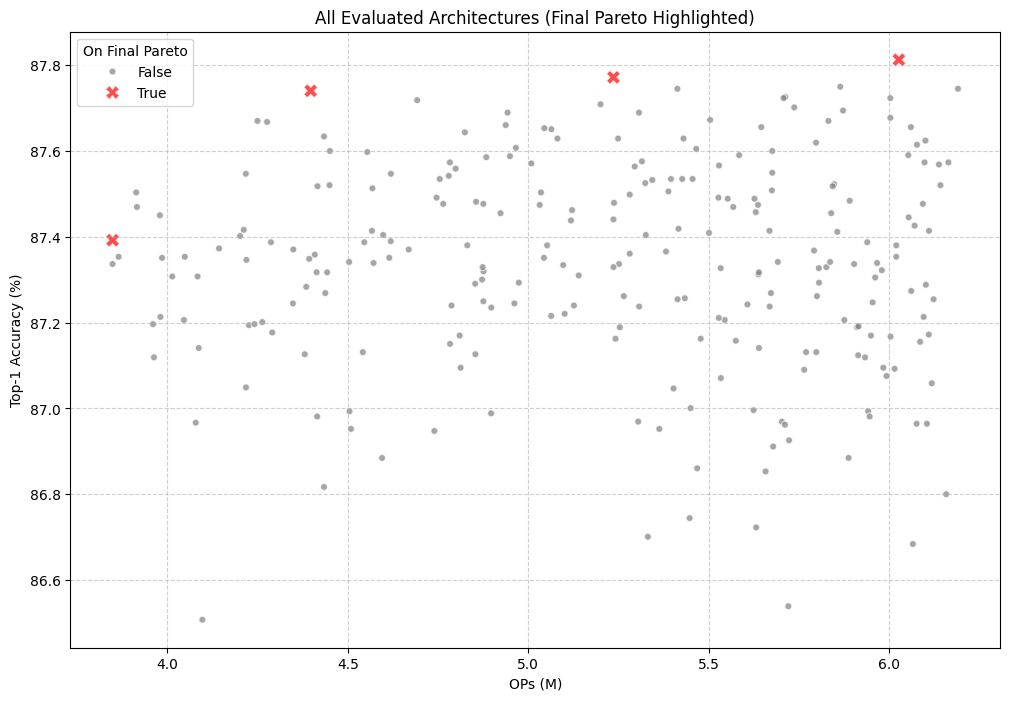

In [4]:
if not df_all_plot.empty:
    plt.figure(figsize=(12, 8))
    if 'on_final_pareto' in df_all_plot.columns and df_all_plot['on_final_pareto'].isin([True, False]).all():
        sns.scatterplot(data=df_all_plot, x='ops', y='accuracy', hue='on_final_pareto',
                        palette={True: 'red', False: 'grey'}, style='on_final_pareto', 
                        markers={True: 'X', False: '.'}, s=100 if any(df_all_plot['on_final_pareto']) else 70, # Make Pareto points bigger
                        alpha=0.7)
        plt.legend(title='On Final Pareto')
    else:
        print("Warning: 'on_final_pareto' column issue. Plotting all points uniformly.")
        sns.scatterplot(data=df_all_plot, x='ops', y='accuracy', color='grey', s=50, alpha=0.7)
    
    plt.title('All Evaluated Architectures (Final Pareto Highlighted)')
    plt.xlabel('OPs (M)')
    plt.ylabel('Top-1 Accuracy (%)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print("No data from vis_dict to plot the scatter of all evaluated architectures.")

### Table of Pareto Optimal Architectures

Details of the architectures found on the Pareto front.

In [5]:
if not df_final_pareto_table.empty:
    print("\n--- Final Architectures on the Pareto Front ---")
    with pd.option_context('display.max_colwidth', None, 'display.width', 1000):
        display(df_final_pareto_table[['OPs_Bucket_Key', 'OPs (M)', 'Accuracy (%)', 'Architecture']])
else:
    print("Final Pareto front table is empty or could not be generated.")


--- Final Architectures on the Pareto Front ---


,OPs_Bucket_Key,OPs (M),Accuracy (%),Architecture
0,3,3.848194,87.391913,"(0, 0, 32, 3, 1, 1, 1, 0, 64, 5, 1, 1, -1, -1, 64, 3, 1, 1, 2, 0, 128, 5, 1, 1, 2, 1, 192, 3, 2, 1, -1, -1, 192, 5, 2, 1, 3, 0, 256, 5, 1, 1, 3, 1, 384, 5, 2, 2, -1, -1, 384, 3, 2, 1, -1, -1, 512, 3, 2, 2, 4, 0, 512, 3, 4, 2, 4, 1, 512, 3, 4, 2, -1, -1, 1024, 3, 2, 2, -1, -1, 1024, 5, 2, 1)"
1,4,4.397058,87.739723,"(0, 0, 48, 3, 1, 1, 1, 0, 64, 3, 1, 1, 1, 1, 64, 3, 1, 1, 2, 0, 128, 5, 1, 1, 2, 1, 128, 3, 1, 1, -1, -1, 192, 5, 2, 1, 3, 0, 256, 5, 1, 1, 3, 1, 384, 5, 2, 2, -1, -1, 384, 3, 2, 1, -1, -1, 512, 3, 2, 2, 4, 0, 512, 3, 4, 2, 4, 1, 512, 3, 4, 2, -1, -1, 1024, 3, 2, 2, -1, -1, 768, 3, 2, 1)"
2,5,5.235714,87.771122,"(0, 0, 48, 3, 1, 1, 1, 0, 64, 5, 1, 1, 1, 1, 64, 3, 1, 1, 2, 0, 128, 5, 1, 1, 2, 1, 128, 3, 1, 1, -1, -1, 192, 5, 2, 1, 3, 0, 256, 3, 1, 1, 3, 1, 384, 5, 2, 2, -1, -1, 384, 3, 2, 1, -1, -1, 512, 3, 2, 2, 4, 0, 512, 3, 1, 2, 4, 1, 512, 5, 4, 2, -1, -1, 512, 3, 2, 2, -1, -1, 768, 3, 2, 2)"
3,6,6.026242,87.812183,"(0, 0, 48, 3, 1, 1, 1, 0, 64, 5, 1, 1, 1, 1, 96, 3, 1, 1, 2, 0, 256, 3, 1, 1, 2, 1, 192, 3, 2, 1, -1, -1, 192, 5, 1, 1, 3, 0, 256, 3, 1, 2, 3, 1, 256, 5, 2, 1, -1, -1, 256, 3, 1, 1, -1, -1, 512, 3, 2, 2, 4, 0, 512, 3, 1, 1, 4, 1, 512, 5, 4, 1, -1, -1, 512, 3, 4, 2, -1, -1, 768, 3, 1, 2)"


## Step 7: Analysis of Fine-Tuning Results

Compare pre-fine-tuning (from `test.py`) and post-fine-tuning (from `train_single.py`) accuracies.

### Fine-tuning Improvement Visualization
Bar chart showing the accuracy improvement due to fine-tuning.

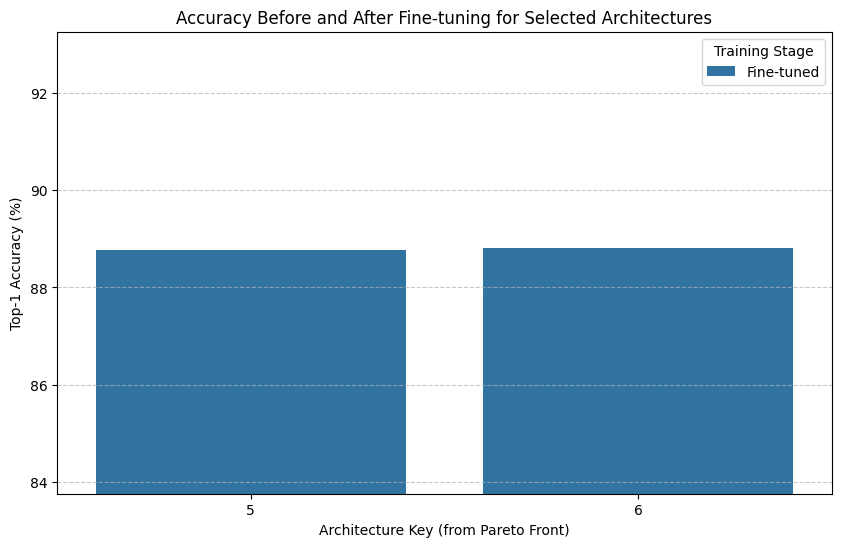

In [6]:
if not df_comparison.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_comparison, x='Key', y='Top-1 Acc (%)', hue='Stage')
    plt.title('Accuracy Before and After Fine-tuning for Selected Architectures')
    plt.xlabel('Architecture Key (from Pareto Front)')
    plt.ylabel('Top-1 Accuracy (%)')
    # Ensure y_min is not greater than y_max if all accuracies are 0 or None
    y_min_plot = 0
    if not df_comparison['Top-1 Acc (%)'].dropna().empty:
        y_min_plot = max(0, df_comparison['Top-1 Acc (%)'].dropna().min() - 5)
    plt.ylim(bottom=y_min_plot) 
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    plt.legend(title='Training Stage')
    plt.show()
else:
    print("No comparison data to plot for fine-tuning improvement.")

## Step 8: Exporting a Model to ONNX for Visualization with Netron

This section demonstrates how to take one of the final architectures (e.g., a fine-tuned model), convert it to its static form, and then export it to the ONNX format. ONNX files can be easily visualized using tools like [Netron](https://netron.app/).

In [7]:
# In your ONNX Export Jupyter Cell (run_all.ipynb)

import torch
import torch.onnx
import os
import models # Your models module
# from utils import tuple2cand # Using manual reshaping
from models._utils import set_onnx_exporting
import numpy as np # For potential use, though not strictly for this reshape

# --- Configuration Variables (These should be defined from your Cell 2) ---
# Ensure these are correctly picked up from Cell 2:
# ops_key_to_test1 (used as export_ops_key)
# base_work_dir
# dataset_name
# architecture_name (e.g., "superbnn_cifar10" - the callable that returns your SuperBNN instance)
# search_info_file

# --- CHOOSE WHICH MODEL TO EXPORT ---
export_ops_key = ops_key_to_test1 # Uses the variable defined in Cell 2

# Define paths and names based on the chosen key and Cell 2 configs
finetuned_model_checkpoint_path = os.path.join(base_work_dir, f"finetuned_ops_key{export_ops_key}", "checkpoint.pth.tar")
onnx_filename = f"nasbnn_{dataset_name}_finetuned_ops_key{export_ops_key}.onnx"
model_source_description = f"Fine-tuned model for OPs Key {export_ops_key} ({dataset_name})"
onnx_output_path = os.path.join(base_work_dir, "onnx_exports")
os.makedirs(onnx_output_path, exist_ok=True)
full_onnx_path = os.path.join(onnx_output_path, onnx_filename)

print(f"--- Preparing to Export Model: {model_source_description} ---")
print(f"Target ONNX file: {full_onnx_path}")

model_to_export = None
loaded_successfully = False
arch_tuple_flat_from_search = None 
current_arch_path_for_static = None 

try:
    print(f"Loading architecture definition for key {export_ops_key} from {search_info_file}...")
    if not os.path.exists(search_info_file):
        raise FileNotFoundError(f"Search info file not found: {search_info_file}")
    
    search_results = torch.load(search_info_file, map_location='cpu')
    pareto_global = search_results.get('pareto_global', {}) 
    
    if export_ops_key not in pareto_global:
        raise ValueError(f"OPs Key {export_ops_key} not found in Pareto front. Available keys: {list(pareto_global.keys())}")
    
    arch_tuple_flat_from_search = pareto_global[export_ops_key] 
    print(f"Loaded FLAT architecture tuple from search: {arch_tuple_flat_from_search}")

    if not isinstance(arch_tuple_flat_from_search, (tuple, list)): 
        raise TypeError(f"Expected arch_tuple_flat_from_search to be a tuple or list, got {type(arch_tuple_flat_from_search)}")
    if len(arch_tuple_flat_from_search) % 6 != 0:
        raise ValueError(f"Flat architecture tuple length {len(arch_tuple_flat_from_search)} is not divisible by 6. Cannot reshape.")

    structured_arch_list_of_tensor_rows = []
    for i_block_config in range(0, len(arch_tuple_flat_from_search), 6):
        raw_block_config = arch_tuple_flat_from_search[i_block_config : i_block_config + 6]
        tensor_block_config_row = [
            torch.tensor(raw_block_config[0], dtype=torch.long), 
            torch.tensor(raw_block_config[1], dtype=torch.long), 
            torch.tensor(raw_block_config[2], dtype=torch.long), 
            torch.tensor(raw_block_config[3], dtype=torch.long), 
            torch.tensor(raw_block_config[4], dtype=torch.long), 
            torch.tensor(raw_block_config[5], dtype=torch.long)  
        ]
        structured_arch_list_of_tensor_rows.append(tensor_block_config_row)
    
    current_arch_path_for_static = structured_arch_list_of_tensor_rows
    print(f"Reshaped architecture to list of lists-of-scalar-tensors (length: {len(current_arch_path_for_static)}).")
    if current_arch_path_for_static: 
        print(f"First element of reshaped arch: {current_arch_path_for_static[0]}")

    model_to_export = models.__dict__[architecture_name]() 
    print(f"Instantiated model '{architecture_name}' (dynamic form).")
    model_to_export.eval() 

    print("\nConverting model to its specific static architecture using to_static...")
    if dataset_name == 'cifar10': dummy_input_shape = (1, 3, 32, 32) 
    elif dataset_name == 'imagenet': dummy_input_shape = (1, 3, 224, 224) 
    else: raise ValueError(f"Unknown dataset '{dataset_name}' for dummy input shape")
    dummy_input_cpu = torch.randn(dummy_input_shape, dtype=torch.float32)
    
    if hasattr(model_to_export, 'to_static'):
        model_to_export.to_static(dummy_input_cpu, sub_path_tuples=current_arch_path_for_static)
        print("Model's to_static method called successfully. Model is now configured to the static architecture.")
    else:
        raise AttributeError(f"Model {architecture_name} does not have a to_static method, which is required.")

    checkpoint_to_load = finetuned_model_checkpoint_path
    print(f"\nLoading finetuned static weights from: {checkpoint_to_load}")
    if not os.path.exists(checkpoint_to_load):
        raise FileNotFoundError(f"Model checkpoint not found: {checkpoint_to_load}")
        
    checkpoint = torch.load(checkpoint_to_load, map_location='cpu')
    state_dict = checkpoint['state_dict']
    
    new_state_dict_static = { (k[7:] if k.startswith('module.') else k) : v for k, v in state_dict.items() }
    
    model_to_export.load_state_dict(new_state_dict_static, strict=True)
    print("Weights loaded successfully into the static model structure.")
    loaded_successfully = True

except Exception as e:
    print(f"ERROR during model preparation for ONNX export: {e}")
    import traceback
    traceback.print_exc()
    loaded_successfully = False


if loaded_successfully and model_to_export:
    model_to_export.eval() 
    
    if dataset_name == 'cifar10': dummy_input_shape_onnx = (1, 3, 32, 32) 
    elif dataset_name == 'imagenet': dummy_input_shape_onnx = (1, 3, 224, 224)
    else: dummy_input_shape_onnx = dummy_input_shape # Fallback, should be defined
    dummy_input_for_onnx = torch.randn(dummy_input_shape_onnx, device='cpu', dtype=torch.float32)
    
    input_names = ["input_image"]
    output_names = ["output_predictions"] 

    print(f"\nAttempting to export model to ONNX: {full_onnx_path}")
    
    set_onnx_exporting(True) 
    try:
        torch.onnx.export(model_to_export,
                          dummy_input_for_onnx,
                          full_onnx_path,
                          input_names=input_names,
                          output_names=output_names,
                          opset_version=12, 
                          verbose=False, 
                         )
        print(f"Model successfully exported to ONNX: {full_onnx_path}")
        print("You can now open this .onnx file with Netron.")
    except Exception as e:
        print(f"ERROR during ONNX export: {e}")
        import traceback
        traceback.print_exc() 
    finally:
        set_onnx_exporting(False) 
else:
    if not model_to_export: 
        print("Model was not instantiated due to errors.")
    elif not loaded_successfully: 
        print("Model preparation (static conversion/loading) failed, skipping ONNX export.")

ImportError: cannot import name 'set_onnx_exporting' from 'models._utils' (c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test08\models\_utils.py)

## Pipeline Complete
All steps of the NAS-BNN pipeline for CIFAR-10 have been executed. Check the respective output directories and logs for results.